#### Capstone 2 Arima Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#get data
eurusd = pd.read_csv(r'eurusd.csv', index_col=0, parse_dates=True, skipinitialspace=True)

In [3]:
eurusd.head()

,Open,High,Low,close,Change,Volume
date,,,,,,
2000-01-03,1.0085,1.0280,1.0055,1.0256,0.0168,0
2000-01-04,1.0255,1.0340,1.0217,1.0301,0.0045,0
2000-01-05,1.0304,1.0400,1.0289,1.0315,0.0014,0
2000-01-06,1.0320,1.0413,1.0283,1.0315,0.0000,0
2000-01-07,1.0317,1.0333,1.0263,1.0296,-0.0019,0


In [4]:
eurusd.tail()

,Open,High,Low,close,Change,Volume
date,,,,,,
2019-12-20,1.1120,1.1125,1.1066,1.1075,-0.0045,119919
2019-12-23,1.1082,1.1095,1.1070,1.1088,0.0014,109071
2019-12-24,1.1088,1.1094,1.1069,1.1088,-0.0001,102337
2019-12-26,1.1093,1.1112,1.1082,1.1095,0.0008,59499
2019-12-27,1.1095,1.1188,1.1094,1.1173,0.0077,157620


In [5]:
eurusd.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-24',
               '2019-12-26', '2019-12-27'],
              dtype='datetime64[ns]', name='date', length=5187, freq=None)

In [6]:
eurusd.dtypes

Open      float64
High      float64
Low       float64
close     float64
Change    float64
Volume      int64
dtype: object

In [7]:
eurusdclose = eurusd.close

In [8]:
eurusdclose.describe() 

count   5187.0000
mean       1.2093
std        0.1666
min        0.8271
25%        1.1105
50%        1.2259
75%        1.3314
max        1.5990
Name: close, dtype: float64

In [9]:
# Check for missing data
print(eurusd.isnull().sum())

Open      0
High      0
Low       0
close     0
Change    0
Volume    0
dtype: int64


There are no missing values in the data set

In [10]:
# Check for outliers

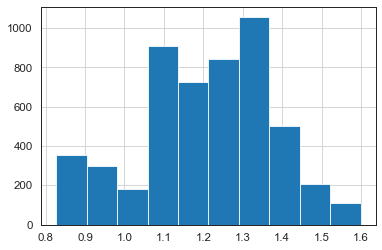

In [11]:
eurusdclose.hist()

#### Statistical Normality Test

In [12]:
# Quantify whether data looks as though it was drawn from a Gaussian distribution, using the D’Agostino’s K² Test.

### p <= alpha: reject H0, not normal.

### p > alpha: fail to reject H0, normal

In [13]:
stat, p = stats.normaltest(eurusd.close)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=137.136, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.43668157335097213
Skewness of normal distribution: -0.28722463936355497


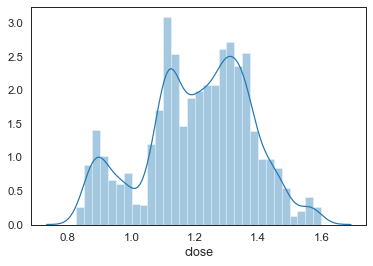

In [14]:
sns.distplot(eurusd.close);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(eurusd.close)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(eurusd.close)))

##### The kurtosis of the distributiion above is less than zero and is light tailed. The distribution is fairly symmetrical

,count,mean,std,min,25%,50%,75%,max
Open,5187.0000,1.2093,0.1666,0.8266,1.1103,1.2258,1.3315,1.5991
High,5187.0000,1.2147,0.1672,0.8322,1.1149,1.2313,1.3372,1.6038
Low,5187.0000,1.2039,0.1658,0.8230,1.1067,1.2196,1.3254,1.5866
close,5187.0000,1.2093,0.1666,0.8271,1.1105,1.2259,1.3314,1.5990
Change,5187.0000,0.0000,0.0074,-0.0348,-0.0041,0.0001,0.0041,0.0467
Volume,5187.0000,119833.2103,155557.6128,0.0000,0.0000,0.0000,229402.5000,763921.0000


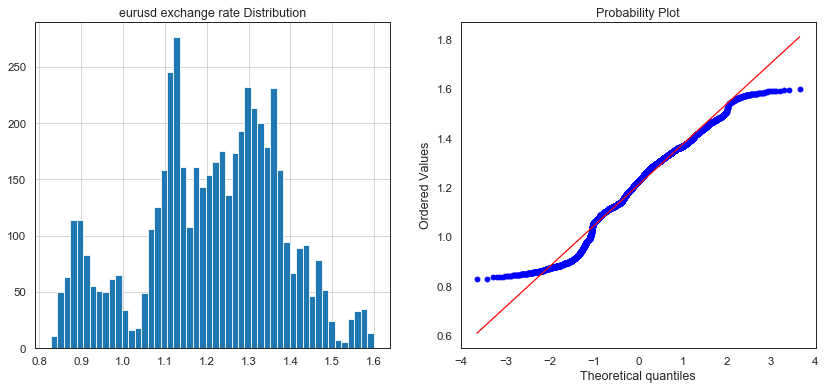

In [19]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
eurusd['close'].hist(bins=50)
plt.title('eurusd exchange rate Distribution')
plt.subplot(1,2,2)
stats.probplot(eurusd['close'], plot=plt);
eurusd.describe().T

#### Stationarity
I used the Dickey–Fuller test to test the null hypothesis that a unit root is present in an autoregressive model. 
Stationary series has constant mean and variance over time. 
Rolling average and the rolling standard deviation of time series do not change over time.

Dickey-Fuller test
Null Hypothesis (H0): Time series has a unit root, meaning it is non-stationary.
Alternate Hypothesis (H1): Suggests the time series does not have a unit root, meaning it is stationary. 

#### p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
#### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

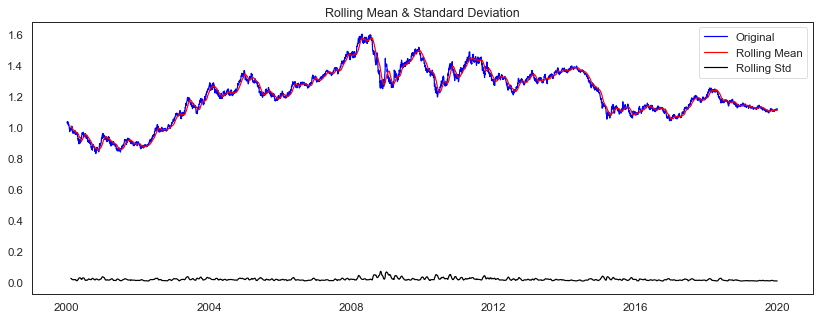

<Results of Dickey-Fuller Test>
Test Statistic                  -1.7338
p-value                          0.4138
#Lags Used                       0.0000
Number of Observations Used   5186.0000
Critical Value (1%)             -3.4316
Critical Value (5%)             -2.8621
Critical Value (10%)            -2.5671
dtype: float64


In [26]:
df2=eurusd.resample('D', how=np.mean)
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(window=30).mean()

    rolstd = timeseries.rolling(window=30).std()

    

    plt.figure(figsize=(14,5))

    sns.despine(left=True)

    orig = plt.plot(timeseries, color='blue',label='Original')

    mean = plt.plot(rolmean, color='red', label='Rolling Mean')

    std = plt.plot(rolstd, color='black', label = 'Rolling Std')



    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')

    plt.show()

    

    print ('<Results of Dickey-Fuller Test>')

    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4],

                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():

        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

test_stationarity(df2.close.dropna())

From the above results, it is clear that the Standard deviation is stationary, while the mean is not. We will reject the null hypothesis H0, the data does not have a unit root and is stationary.